# Named Entity Recognition (NER)
El reconocimiento de entidades nombradas (NER), también llamado fragmentación de entidades o extracción de entidades, es un componente del procesamiento de lenguaje natural (PLN) que identifica categorías predefinidas de objetos en un cuerpo de texto.

Básicamente, el NER es el proceso de tomar una cadena de texto (es decir, una frase, un párrafo o un documento entero), e identificar y clasificar las entidades que se refieren a cada categoría.

## Bibliotecas

In [ ]:
import pandas as pd
import re

In [ ]:
df = pd.read_csv("protocolos_completo_limpios.csv")

## Paso 1. Identificar las entidades por "reconocer"
Pensamos que una de las estrategías a seguir para saber que entidades son las que va a reconocer el sistemta era tomar las palabras clave de los protocolos, por lo que hicimos lo siguiente:

`df = pd.read_csv("protocolos_completo_limpios.csv")`

`palabras_clave = (df['claves'].str.split(',').explode().str.strip().drop_duplicates())`

`palabras_clave.to_csv("palabras_clave.txt", index=False, header=False)`

Y luego limpiamos los puntos y puntuación (. , ; :) y convertimos a minúsculas las palabras clave, además establecimos la condición de que para ser candidata a ser una entidad por reconocer, la oración debía contener por lo menos 2 palabras.

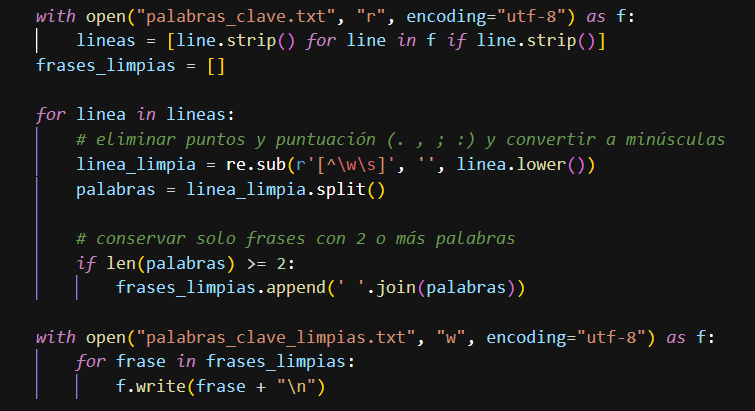

Luego de exportar las palabras clave a un txt, estas se limpiaron manualmente, eliminando frases o palabras que no fueran consideradas de interés, por ejemplo "mariposa monarca".

## Paso 2. Reconocer las entidades dentro de los protocolos

### Carga de palabras_clave_limpias.txt

In [8]:
with open("palabras_clave_limpias.txt", "r", encoding="utf-8") as f:
    frases_clave = [line.strip().lower() for line in f if line.strip()]
frases_clave_tokens = [frase.split() for frase in frases_clave if len(frase.split()) >= 2]

### Convertir el contenido de la columna a minusculas, eliminar signos de puntuacion como , . ;

In [ ]:
def limpiar_columna_texto(df, columna):
    return df[columna].apply(lambda x: re.sub(r'[.,;]', '', str(x).lower()) if pd.notnull(x) else x)

In [10]:
titulos = limpiar_columna_texto(df, 'Titulo')
resumen = limpiar_columna_texto(df, 'resumen')
objetivos = limpiar_columna_texto(df, 'objetivos')

In [11]:
titulos.head(3)

0         laboratorio virtual de electrónica analógica
1    sistema de control automático para un invernad...
2    aplicación web de un pizarrón virtual con cola...
Name: Titulo, dtype: object

### Etiquetado de texto en formato BIO
El formato BIO sirve para etiquetar tokens en un texto y marcar cuáles forman parte de una entidad, donde:

| Etiqueta | Significado |
|----------|-------------|
| B-XXX    | Beginning: inicio de una entidad del tipo XXX |
| I-XXX    | Inside: continuación de la entidad del mismo tipo |
| O        | Outside: el token no pertenece a ninguna entidad |

Ejemplo: 
```bash
laboratorio        B-TECH
virtual            I-TECH
de                 O
electrónica        B-TECH
analógica          I-TECH
```

Por lo tanto, se reconoce como una entidad `TECH` a "**laboratorio virtual**" y como otra entidad `TECH` a "**electrónica analógica**"

* `TECH`: Se refiere a entidades con conceptos tecnológicos o técnicos.


In [12]:
def etiquetar_texto_con_bio(texto, frases_clave_tokens):
    tokens = texto.strip().split()
    tokens_lower = [t.lower() for t in tokens]
    etiquetas = ['O'] * len(tokens)

    for frase_tokens in frases_clave_tokens:
        n = len(frase_tokens)

        for i in range(len(tokens) - n + 1):
            if tokens_lower[i:i + n] == frase_tokens:
                etiquetas[i] = 'B-TECH'
                for j in range(1, n):
                    etiquetas[i + j] = 'I-TECH'

    return list(zip(tokens, etiquetas))

In [ ]:
def procesar_columna(nombre_columna, series_limpia):
    archivo_salida = f"BIO_{nombre_columna.lower()}.txt"
    with open(archivo_salida, "w", encoding="utf-8") as f:
        for texto in series_limpia:
            resultado_bio = etiquetar_texto_con_bio(texto, frases_clave_tokens)
            for token, etiqueta in resultado_bio:
                f.write(f"{token} {etiqueta}\n")
            f.write("\n")  # linea en blanco entre registros para separarlos

In [14]:
procesar_columna("Titulo", titulos)
procesar_columna("Resumen", resumen)
procesar_columna("Objetivos", objetivos)